In [1]:
import numpy as np
from astropy.io.votable import parse
import pandas as pd

%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

In [2]:
# This notebook is for managing the metadata for the Lori Allen Data Set

# Initialize variable
neo_metadata_df = None

# Set the range of nights to ingest into the data frame
for night_num in range(1,32):
    
    # Create the data frame
    metadata_df = pd.DataFrame()
    
    # Create a string for the give night's file name
    night_str = 'night_%i.vot' % night_num
    
    # Ingest data into a table
    votable = parse(night_str)
    table = votable.get_first_table()
    
    # Turn the table into a data array
    data = table.array
    
    # Load file names for future use
    file_names = data['dtacqnam'].data
    
    # Create fields in the data frame with given values
    metadata_df['visit_id'] = np.array([x[-14:-8] for x in file_names])
    metadata_df['date_obs'] = data['date_obs'].data
    metadata_df['ra'] = data['ra'].data
    metadata_df['dec'] = data['dec'].data
    metadata_df['product'] = data['prodtype'].data
    metadata_df['filename'] = file_names
    metadata_df['survey_night'] = night_num
    
    # Now add the data frame for a given night to the total data frame
    if neo_metadata_df is None:
        neo_metadata_df = metadata_df
    else:
        neo_metadata_df = pd.concat([neo_metadata_df, metadata_df])

# Only keep image data
neo_metadata_df = neo_metadata_df[neo_metadata_df['product'] == b'image']
neo_metadata_df = neo_metadata_df.reset_index(drop=True)

<IPython.core.display.Javascript object>


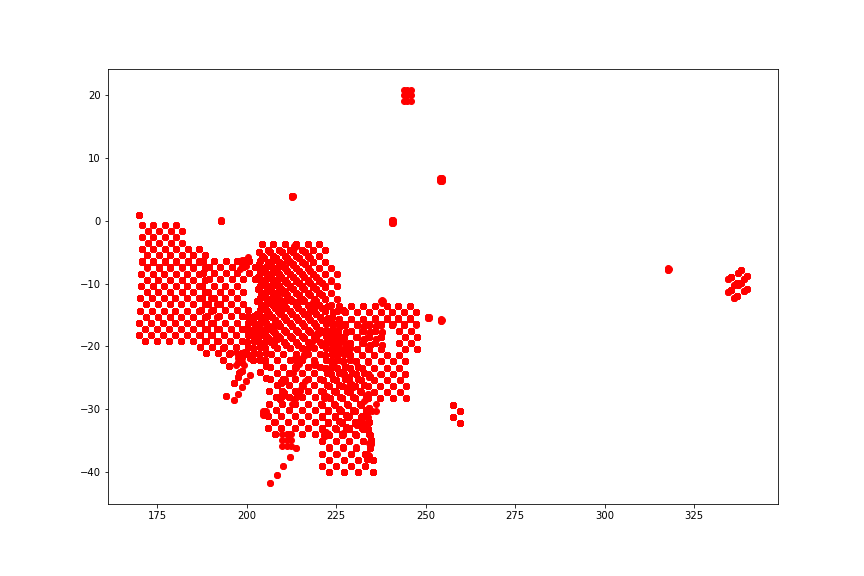

In [39]:
arcsec2degree = 0.000277778

pixscale = 0.2637 #arcsec/px
height   = 2048 * pixscale * arcsec2degree
width    = 4096 * pixscale * arcsec2degree

visit_id = neo_metadata_df["visit_id"]
ra       = neo_metadata_df["ra"]
dec      = neo_metadata_df["dec"]
angle    = [0]*len(ra)

fig, ax = plt.subplots(figsize=(12, 8))

rect_patches = []
for i, r, d, a in zip(visit_id, ra, dec, angle):
    # this will likely kill the notebook
    #annot = ax.text(r-0.001, d-0.001, i, fontsize=12)
    #                 lower left corner        height  width  angle
    rect = Rectangle((r-height/2., d-width/2.), height, width, a)
    rect_patches.append(rect)
rect_patches_collection = PatchCollection(rect_patches, alpha=0.1)
ax.add_collection(rect_patches_collection)

ax.scatter(ra, dec, color="red")

plt.show()

In [33]:
# This value determines how close RA has to be in order to be considered "equal"
ra_tol = 5e-2
# Same as Ra_Tol, but for DEC
dec_tol = 5e-2

# Minimum number of visits
min_num_visits = 3

# Make a copy that we can manipulate
df_copy = neo_metadata_df

# Drop a few unnecessary columns
df_copy = df_copy.drop(['product','filename'],axis=1)

# Set a maxinimum number of interations just in case
max_iter = neo_metadata_df.axes[0][-1]
i = 0

# Initialize an array that will hold the dataframes for the sorted fields
sorted_fields = []

# This while loop interates over a given field, groups the data, and adds it to Sorted_Fields
while (not df_copy.empty) and (i<max_iter):
    # Save the values for the current field
    current_ra  = df_copy['ra'][0]
    current_dec = df_copy['dec'][0]
    current_id  = df_copy['visit_id'][0]
    
    # Find all entries that are a part of this field.
    # Note that we have to use np.close because even within a field, RA and DEC vary somewhat
    ra_mask  = np.isclose(current_ra,df_copy['ra'], atol=ra_tol)
    dec_mask = np.isclose(current_dec,df_copy['dec'], atol=dec_tol)
    duplicate_mask = (df_copy['visit_id'] == current_id)
    
    # Save the indicies for this field
    indexes = df_copy.index[ra_mask & dec_mask]
    
    # Create a new dataframe that only includes the entries of this field
    new_field = df_copy.loc[indexes]
    new_field.sort_values(['date_obs'])
    new_field = new_field.reset_index(drop=True)
    
    # Append the new field to the overall array
    sorted_fields.append(new_field)
    df_copy = df_copy.drop(indexes)
    df_copy = df_copy.reset_index(drop=True)
    i+=1

# Clean up the output
for i,_ in enumerate(sorted_fields):
    # Convert the visit_id field to a numeric value
    sorted_fields[i]["visit_id"] = pd.to_numeric(sorted_fields[i]["visit_id"])
    
    # Find the index of duplicate visit_id values
    no_duplicates = sorted_fields[i]["visit_id"].drop_duplicates()
    
    # Drop the duplicates
    sorted_fields[i] = sorted_fields[i].loc[no_duplicates.index]
    
    # Reset indicies
    sorted_fields[i] = sorted_fields[i].reset_index(drop=True)
    
# Now sort the array based on the length of the series
sorted_fields = sorted(sorted_fields, key=len, reverse=True)

# Strip out all values that have fewer visits than Min_Num_Visits
temp_fields = []
for field in sorted_fields:
    if len(field) > min_num_visits:
        temp_fields.append(field)

sorted_fields = temp_fields

In [7]:
# Print the sorted lists of fields. The longest (by number of visits) fields will be first
_=[print(field) for field in sorted_fields]


    visit_id                    date_obs          ra        dec  survey_night
0     439116  b'2015-05-20 10:12:35.083'  257.655417 -29.255417            20
1     439120  b'2015-05-20 10:17:14.409'  257.655333 -29.256250            20
2     439124  b'2015-05-20 10:23:13.327'  257.657042 -29.256778            20
3     439128  b'2015-05-20 10:29:16.399'  257.656083 -29.255667            20
4     439707  b'2015-05-21 10:02:26.888'  257.652042 -29.258389            21
5     439711  b'2015-05-21 10:07:16.391'  257.651875 -29.259500            21
6     439715  b'2015-05-21 10:11:54.434'  257.652792 -29.259333            21
7     439719  b'2015-05-21 10:16:36.741'  257.652708 -29.259056            21
8     439723  b'2015-05-21 10:22:09.298'  257.653875 -29.259528            21
9     440411  b'2015-05-22 09:57:57.005'  257.650625 -29.258944            22
10    440415  b'2015-05-22 10:02:49.875'  257.649542 -29.259583            22
11    440419  b'2015-05-22 10:07:38.801'  257.650208 -29.259806 

24    307458  b'2014-04-28 23:43:24.867'  201.775500 -22.222111             7
    visit_id                    date_obs          ra        dec  survey_night
0     304136  b'2014-04-23 23:20:04.238'  201.756833 -20.252028             2
1     304140  b'2014-04-23 23:24:55.628'  201.758625 -20.251917             2
2     304144  b'2014-04-23 23:29:46.282'  201.761333 -20.252028             2
3     304148  b'2014-04-23 23:34:56.684'  201.739375 -20.255750             2
4     304152  b'2014-04-23 23:40:03.834'  201.762417 -20.252194             2
5     305469  b'2014-04-25 23:21:21.424'  201.759375 -20.247806             4
6     305473  b'2014-04-25 23:26:47.759'  201.735125 -20.252583             4
7     305477   b'2014-04-25 23:31:51.79'  201.760542 -20.248889             4
8     305481  b'2014-04-25 23:36:27.483'  201.758458 -20.249694             4
9     305485  b'2014-04-25 23:40:59.884'  201.758542 -20.248333             4
10    306151  b'2014-04-26 23:18:32.727'  201.758083 -20.248361 

24    441281  b'2015-05-24 00:42:55.634'  224.908292 -25.345944            24
    visit_id                    date_obs          ra        dec  survey_night
0     438621  b'2015-05-20 00:27:22.919'  224.890333 -27.288139            20
1     438625  b'2015-05-20 00:31:57.217'  224.892000 -27.287306            20
2     438629  b'2015-05-20 00:36:30.948'  224.890833 -27.287111            20
3     438633  b'2015-05-20 00:41:05.069'  224.889583 -27.287528            20
4     438637  b'2015-05-20 00:45:47.035'  224.890125 -27.288361            20
5     439272  b'2015-05-21 00:37:45.673'  224.888500 -27.287722            21
6     439276  b'2015-05-21 00:42:24.657'  224.887792 -27.286000            21
7     439280  b'2015-05-21 00:47:04.007'  224.888458 -27.286250            21
8     439284  b'2015-05-21 00:51:43.733'  224.888208 -27.286694            21
9     439288  b'2015-05-21 00:56:25.359'  224.887917 -27.287194            21
10    440032  b'2015-05-22 00:42:33.061'  224.891125 -27.288833 

24    441563  b'2015-05-24 06:14:55.956'  237.419333 -20.444667            24
    visit_id                    date_obs          ra        dec  survey_night
0     438908  b'2015-05-20 06:07:56.265'  237.411333 -18.473389            20
1     438912  b'2015-05-20 06:12:33.896'  237.411458 -18.473167            20
2     438916  b'2015-05-20 06:17:17.806'  237.411208 -18.472750            20
3     438920   b'2015-05-20 06:21:55.73'  237.411500 -18.472722            20
4     438924   b'2015-05-20 06:26:42.28'  237.412375 -18.472472            20
5     439558  b'2015-05-21 07:07:31.855'  237.408917 -18.474694            21
6     439562  b'2015-05-21 07:12:11.924'  237.409458 -18.474750            21
7     439566  b'2015-05-21 07:16:52.969'  237.409458 -18.474667            21
8     439570  b'2015-05-21 07:21:31.035'  237.409708 -18.475083            21
9     439574  b'2015-05-21 07:26:12.798'  237.409958 -18.475056            21
10    440318  b'2015-05-22 08:08:28.831'  237.407708 -18.473500 

24    533242  b'2016-04-01 04:13:46.651'  177.048792 -6.461694            29
    visit_id                    date_obs          ra       dec  survey_night
0     530849  b'2016-03-28 04:45:58.494'  178.664125 -7.418667            25
1     530853  b'2016-03-28 04:50:32.977'  178.664333 -7.418444            25
2     530857  b'2016-03-28 04:55:05.922'  178.664708 -7.419167            25
3     530861  b'2016-03-28 04:59:39.764'  178.664292 -7.419611            25
4     530865  b'2016-03-28 05:04:14.705'  178.665167 -7.419528            25
5     531456   b'2016-03-29 03:56:55.56'  178.663417 -7.417111            26
6     531460  b'2016-03-29 04:01:30.699'  178.664375 -7.416444            26
7     531464  b'2016-03-29 04:06:07.497'  178.665125 -7.416306            26
8     531468  b'2016-03-29 04:10:39.694'  178.665333 -7.417250            26
9     531472  b'2016-03-29 04:15:14.033'  178.664167 -7.417417            26
10    532098  b'2016-03-30 04:32:19.935'  178.664500 -7.427972            27

24    533422  b'2016-04-01 07:40:41.007'  183.419167 -10.377667            29
    visit_id                    date_obs          ra        dec  survey_night
0     531029  b'2016-03-28 08:15:00.751'  185.046208 -11.361556            25
1     531033  b'2016-03-28 08:19:33.784'  185.045542 -11.362111            25
2     531037  b'2016-03-28 08:24:12.668'  185.045667 -11.362722            25
3     531041  b'2016-03-28 08:28:51.958'  185.045958 -11.361917            25
4     531045  b'2016-03-28 08:33:24.443'  185.045875 -11.361556            25
5     531596  b'2016-03-29 06:42:14.472'  185.043000 -11.364000            26
6     531600  b'2016-03-29 06:46:51.016'  185.043000 -11.364500            26
7     531604  b'2016-03-29 06:51:25.195'  185.042750 -11.363389            26
8     531608  b'2016-03-29 06:56:01.113'  185.042583 -11.363417            26
9     531612  b'2016-03-29 07:00:37.258'  185.042500 -11.364472            26
10    532218  b'2016-03-30 06:51:30.675'  185.045792 -11.373083 

19    305725  b'2014-04-26 04:22:11.613'  215.406208 -12.421389             4
    visit_id                    date_obs          ra        dec  survey_night
0     303782  b'2014-04-23 05:26:37.991'  213.734667 -15.349111             1
1     303786  b'2014-04-23 05:31:11.421'  213.734542 -15.351333             1
2     303790  b'2014-04-23 05:35:44.035'  213.735958 -15.352111             1
3     303794  b'2014-04-23 05:40:17.453'  213.735167 -15.350000             1
4     303798  b'2014-04-23 05:44:51.055'  213.735375 -15.349972             1
5     304473  b'2014-04-24 05:57:59.341'  213.735875 -15.350139             2
6     304477  b'2014-04-24 06:02:33.037'  213.737542 -15.349861             2
7     304481  b'2014-04-24 06:07:10.055'  213.735875 -15.349806             2
8     304485  b'2014-04-24 06:11:44.164'  213.736875 -15.349833             2
9     304489  b'2014-04-24 06:16:16.711'  213.737500 -15.350639             2
10    305119  b'2014-04-25 05:57:52.807'  213.732375 -15.348389 

    visit_id                    date_obs          ra        dec  survey_night
0     310258  b'2014-05-05 03:23:42.218'  230.156833 -30.198278            12
1     310262  b'2014-05-05 03:28:22.251'  230.158375 -30.198583            12
2     310266  b'2014-05-05 03:32:59.803'  230.158042 -30.198194            12
3     310270  b'2014-05-05 03:37:42.139'  230.157750 -30.198750            12
4     310274  b'2014-05-05 03:42:19.936'  230.158000 -30.198444            12
5     310445  b'2014-05-05 07:49:09.321'  230.150667 -30.200194            12
6     310449  b'2014-05-05 07:53:46.125'  230.150500 -30.200917            12
7     310453  b'2014-05-05 07:58:19.066'  230.150708 -30.200167            12
8     310457  b'2014-05-05 08:02:58.994'  230.150083 -30.200778            12
9     310461  b'2014-05-05 08:07:33.498'  230.151042 -30.200750            12
10    310887  b'2014-05-06 03:40:01.572'  230.157417 -30.199528            13
11    310891   b'2014-05-06 03:44:42.09'  230.158958 -30.201000 

    visit_id                    date_obs          ra        dec  survey_night
0     433831   b'2015-04-18 04:35:59.35'  197.154708 -14.229833            15
1     433835  b'2015-04-18 04:40:42.269'  197.153958 -14.229806            15
2     433839  b'2015-04-18 04:45:22.297'  197.154625 -14.230583            15
3     433843  b'2015-04-18 04:50:02.457'  197.154042 -14.229778            15
4     433847  b'2015-04-18 04:54:42.749'  197.154500 -14.230083            15
5     434509  b'2015-04-19 04:20:20.932'  197.156333 -14.230667            16
6     434513  b'2015-04-19 04:25:01.922'  197.157833 -14.231306            16
7     434517  b'2015-04-19 04:29:42.284'  197.157792 -14.231278            16
8     434521  b'2015-04-19 04:34:22.881'  197.158792 -14.231639            16
9     434525   b'2015-04-19 04:39:02.57'  197.158792 -14.231250            16
10    435398  b'2015-04-21 04:24:50.402'  197.154750 -14.233194            18
11    435402  b'2015-04-21 04:29:32.974'  197.154292 -14.233361 

19    441601  b'2015-05-24 06:59:27.405'  239.077750 -13.569972            24
    visit_id                    date_obs          ra        dec  survey_night
0     438946   b'2015-05-20 06:52:35.85'  239.070083 -15.545944            20
1     438950   b'2015-05-20 06:57:17.72'  239.070042 -15.546000            20
2     438954  b'2015-05-20 07:01:54.201'  239.069750 -15.546194            20
3     438958  b'2015-05-20 07:06:35.217'  239.070250 -15.545444            20
4     438962  b'2015-05-20 07:11:14.926'  239.069917 -15.545111            20
5     439596  b'2015-05-21 07:52:02.259'  239.068417 -15.547278            21
6     439600  b'2015-05-21 07:56:41.977'  239.068500 -15.547361            21
7     439604  b'2015-05-21 08:01:21.814'  239.068875 -15.546917            21
8     439608  b'2015-05-21 08:06:01.003'  239.068542 -15.546722            21
9     439612  b'2015-05-21 08:10:44.169'  239.069250 -15.546972            21
10    440356  b'2015-05-22 08:53:37.413'  239.069917 -15.544917 

    visit_id                    date_obs          ra       dec  survey_night
0     303542  b'2014-04-23 00:48:22.064'  204.218833 -3.608222             1
1     303546  b'2014-04-23 00:52:55.728'  204.219083 -3.605889             1
2     303550  b'2014-04-23 00:57:30.487'  204.217958 -3.604278             1
3     303554  b'2014-04-23 01:02:04.155'  204.219708 -3.605611             1
4     303558  b'2014-04-23 01:06:39.375'  204.218917 -3.606694             1
5     304233  b'2014-04-24 01:16:21.308'  204.222708 -3.607417             2
6     304237  b'2014-04-24 01:20:53.739'  204.224042 -3.607361             2
7     304241  b'2014-04-24 01:25:33.433'  204.223500 -3.607028             2
8     304245  b'2014-04-24 01:30:13.116'  204.223167 -3.607472             2
9     304249  b'2014-04-24 01:34:51.318'  204.223542 -3.606500             2
10    304879  b'2014-04-25 01:15:00.736'  204.217375 -3.605722             3
11    304883  b'2014-04-25 01:19:41.898'  204.217708 -3.606278             3

    visit_id                    date_obs          ra        dec  survey_night
0     306965  b'2014-04-28 03:02:11.351'  215.320958 -28.107583             6
1     306969  b'2014-04-28 03:06:58.207'  215.320292 -28.107083             6
2     306973  b'2014-04-28 03:11:46.916'  215.321750 -28.108111             6
3     306977  b'2014-04-28 03:16:40.738'  215.321417 -28.108944             6
4     306981  b'2014-04-28 03:21:30.782'  215.322417 -28.108917             6
5     307623  b'2014-04-29 02:54:51.114'  215.319000 -28.108111             7
6     307627  b'2014-04-29 02:59:31.997'  215.319833 -28.108111             7
7     307631  b'2014-04-29 03:04:11.751'  215.319875 -28.108083             7
8     307635  b'2014-04-29 03:08:50.393'  215.319000 -28.107889             7
9     307639  b'2014-04-29 03:13:31.759'  215.319667 -28.107861             7
10    308749  b'2014-05-02 03:58:19.596'  215.319167 -28.108583            10
11    308753   b'2014-05-02 04:02:56.71'  215.319708 -28.108472 

   visit_id                    date_obs          ra        dec  survey_night
0    305647  b'2014-04-26 02:49:21.081'  210.265250 -21.233583             4
1    305651  b'2014-04-26 02:54:01.937'  210.264833 -21.233528             4
2    305655  b'2014-04-26 02:58:39.503'  210.263917 -21.233083             4
3    305659   b'2014-04-26 03:03:20.92'  210.265542 -21.234778             4
4    305663  b'2014-04-26 03:08:00.655'  210.265292 -21.233944             4
5    306329  b'2014-04-27 02:47:31.894'  210.265125 -21.232250             5
6    306333  b'2014-04-27 02:52:11.514'  210.264333 -21.232167             5
7    306337  b'2014-04-27 02:56:49.964'  210.264333 -21.231250             5
8    306341  b'2014-04-27 03:01:30.458'  210.265750 -21.231917             5
9    306345  b'2014-04-27 03:06:09.596'  210.266625 -21.233278             5
   visit_id                    date_obs          ra        dec  survey_night
0    305648  b'2014-04-26 02:50:29.151'  211.986250 -22.220000             4

   visit_id                    date_obs          ra        dec  survey_night
0    538230  b'2016-05-01 01:31:17.405'  206.373958 -10.848528            30
1    538234  b'2016-05-01 01:35:50.794'  206.375083 -10.848583            30
2    538238  b'2016-05-01 01:40:27.045'  206.375458 -10.851472            30
3    538242  b'2016-05-01 01:45:02.999'  206.376000 -10.850917            30
4    538246   b'2016-05-01 01:49:36.85'  206.376208 -10.849722            30
5    538963  b'2016-05-03 01:59:35.456'  206.371500 -10.850028            31
6    538967   b'2016-05-03 02:04:10.97'  206.369542 -10.849083            31
7    538971  b'2016-05-03 02:08:47.372'  206.369083 -10.849667            31
8    538975  b'2016-05-03 02:13:23.546'  206.369583 -10.848778            31
9    538979  b'2016-05-03 02:17:58.673'  206.369500 -10.850806            31
   visit_id                    date_obs          ra        dec  survey_night
0    538231  b'2016-05-01 01:32:26.157'  208.004250 -11.834806            30

4    305823  b'2014-04-26 06:14:55.514'  217.065167 -21.235250             4
   visit_id                    date_obs          ra        dec  survey_night
0    305808  b'2014-04-26 05:57:45.675'  218.785917 -22.220417             4
1    305812   b'2014-04-26 06:02:18.27'  218.785542 -22.221556             4
2    305816  b'2014-04-26 06:06:51.341'  218.785167 -22.221444             4
3    305820    b'2014-04-26 06:11:29.4'  218.785958 -22.222667             4
4    305824  b'2014-04-26 06:16:04.285'  218.785792 -22.223083             4
   visit_id                    date_obs          ra        dec  survey_night
0    305809  b'2014-04-26 05:58:53.375'  218.772958 -20.246500             4
1    305813  b'2014-04-26 06:03:25.842'  218.771458 -20.246944             4
2    305817  b'2014-04-26 06:07:59.826'  218.772958 -20.247722             4
3    305821  b'2014-04-26 06:12:37.232'  218.773583 -20.249139             4
4    305825  b'2014-04-26 06:17:13.639'  218.772375 -20.248333             4

In [34]:
len(sorted_fields)

786